In [22]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import getpass  # Para obtener la contraseña sin mostrar la entrada
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df_combined = pd.read_csv('df_combined.csv')

In [24]:
df_combined

,date,price_bitcoin,price_gold,price_sp500,change_bitcoin,change_gold,vix,interest_rate,cpi,inflation
0,2015-01-02,315,1186,2058,0.10,0.18,17.79,0.01,234.82,0.76
1,2015-01-05,275,1204,2021,3.82,1.50,19.92,0.00,234.84,0.76
2,2015-01-06,282,1219,2003,2.70,1.28,21.12,0.02,234.84,0.76
3,2015-01-07,291,1211,2026,3.21,-0.71,19.31,0.02,234.84,0.76
4,2015-01-08,283,1208,2062,-2.97,-0.18,17.01,0.02,234.85,0.76
...,...,...,...,...,...,...,...,...,...,...
2288,2024-02-05,42697,2043,4943,0.27,-0.53,13.67,5.23,307.54,3.35
2289,2024-02-06,43088,2051,4954,0.91,0.42,13.06,5.22,307.56,3.35
2290,2024-02-07,44340,2052,4995,2.91,0.01,12.83,5.22,307.58,3.35
2291,2024-02-08,45293,2048,4998,2.15,-0.19,12.79,5.22,307.60,3.35


Primero, leemos los datos del archivo CSV y nos aseguramos de insertar las fechas únicas en la tabla dates.

In [ ]:
# Conexión a la base de datos
bd = "financial_analysis"
password = "123456"  # Tu contraseña
connection_string = 'mysql+pymysql://root:' + password + '@localhost/' + bd
engine = create_engine(connection_string)

# Leer el archivo CSV
df_combined = pd.read_csv('df_combined.csv')

# Extraer las fechas únicas del CSV
df_dates = pd.DataFrame(df_combined['date'].unique(), columns=['date'])

# Insertar las fechas en la tabla 'dates'
df_dates.to_sql('dates', con=engine, if_exists='append', index=False)

Después de insertar las fechas, hacemos un merge del archivo CSV con la tabla dates para asignar el id_date correcto en cada fila del CSV.

In [ ]:
# Cargar las fechas desde la tabla 'dates' para obtener el id_date
dates_from_db = pd.read_sql('SELECT * FROM dates', con=engine)

# Asegurarse de que las fechas estén en el mismo formato
df_combined['date'] = pd.to_datetime(df_combined['date']).dt.date
dates_from_db['date'] = pd.to_datetime(dates_from_db['date']).dt.date

# Hacer el merge entre el CSV y la tabla 'dates' usando la columna 'date'
df_merged = pd.merge(df_combined, dates_from_db, how='left', on='date')

# Eliminar la columna 'id_date_x' y renombrar 'id_date_y' a 'id_date'
df_merged.drop(columns=['id_date_x'], inplace=True)
df_merged.rename(columns={'id_date_y': 'id_date'}, inplace=True)

Una vez hecho el merge y corregido el id_date, dividimos los datos entre los activos y los factores económicos y los insertamos en las tablas correspondientes.

In [ ]:
# Dividir el DataFrame en las partes necesarias con el id_date ya corregido
assets_df = df_merged[['id_date', 'price_bitcoin', 'price_gold', 'price_sp500', 'change_bitcoin', 'change_gold']]
economic_factors_df = df_merged[['id_date', 'vix', 'interest_rate', 'cpi', 'inflation']]

# Insertar los datos en las tablas correspondientes
assets_df.to_sql('assets', con=engine, if_exists='append', index=False)
economic_factors_df.to_sql('economic_factors', con=engine, if_exists='append', index=False)

Conexión con MySQL para traer lsa consultas a Python

In [25]:
# Obtener la contraseña de forma segura
password = getpass.getpass("Introduce la contraseña de MySQL: ")

# Configuración de la base de datos y la conexión
bd = "financial_analysis"  # Nombre de tu base de datos
connection_string = 'mysql+pymysql://root:' + password + '@localhost/' + bd
engine = create_engine(connection_string)

In [26]:
# Consulta 1: Crecimiento anual de Bitcoin, Oro y S&P 500
consulta1 = """
SELECT
    year(d.date) AS year,
    a.price_bitcoin,
    a.price_gold,
    a.price_sp500,
    ROUND( (a.price_bitcoin - LAG(a.price_bitcoin) OVER (ORDER BY year(d.date))) / LAG(a.price_bitcoin) OVER (ORDER BY year(d.date)) * 100, 2) AS bitcoin_growth,
    ROUND( (a.price_gold - LAG(a.price_gold) OVER (ORDER BY year(d.date))) / LAG(a.price_gold) OVER (ORDER BY year(d.date)) * 100, 2) AS gold_growth,
    ROUND( (a.price_sp500 - LAG(a.price_sp500) OVER (ORDER BY year(d.date))) / LAG(a.price_sp500) OVER (ORDER BY year(d.date)) * 100, 2) AS sp500_growth
FROM 
    assets a
JOIN 
    dates d ON a.id_date = d.id_date
WHERE 
    d.date IN (SELECT MAX(d2.date) FROM dates d2 GROUP BY year(d2.date))
ORDER BY 
    year(d.date);
"""
df1 = pd.read_sql(consulta1, con=engine)

In [27]:
df1

,year,price_bitcoin,price_gold,price_sp500,bitcoin_growth,gold_growth,sp500_growth
0,2015,430.0,1060.0,2044.0,NaN,NaN,NaN
1,2016,959.0,1152.0,2239.0,123.02,8.68,9.54
2,2017,14393.0,1309.0,2674.0,1400.83,13.63,19.43
3,2018,3709.0,1281.0,2507.0,-74.23,-2.14,-6.25
4,2019,7196.0,1523.0,3231.0,94.01,18.89,28.88
5,2020,28949.0,1895.0,3756.0,302.29,24.43,16.25
6,2021,46220.0,1829.0,4766.0,59.66,-3.48,26.89
7,2022,16607.0,1826.0,3840.0,-64.07,-0.16,-19.43
8,2023,42072.0,2072.0,4770.0,153.34,13.47,24.22
9,2024,47545.0,2039.0,5027.0,13.01,-1.59,5.39


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


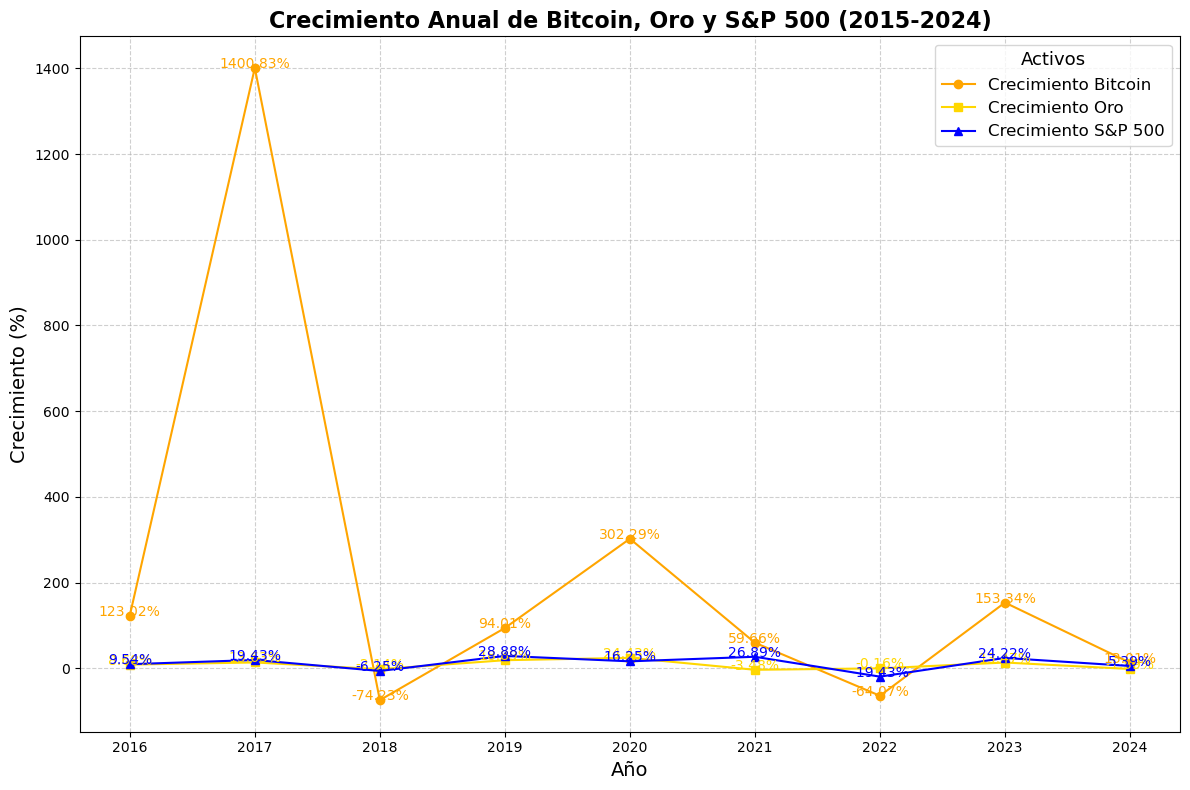

In [28]:
# Mejorado para consulta 1: Crecimiento anual de Bitcoin, Oro y S&P 500
plt.figure(figsize=(12, 8))

# Gráfico de líneas para cada activo
plt.plot(df1['year'], df1['bitcoin_growth'], label='Crecimiento Bitcoin', marker='o', linestyle='-', color='orange')
plt.plot(df1['year'], df1['gold_growth'], label='Crecimiento Oro', marker='s', linestyle='-', color='gold')
plt.plot(df1['year'], df1['sp500_growth'], label='Crecimiento S&P 500', marker='^', linestyle='-', color='blue')

# Títulos y etiquetas
plt.title('Crecimiento Anual de Bitcoin, Oro y S&P 500 (2015-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Crecimiento (%)', fontsize=14)

# Leyenda
plt.legend(title='Activos', title_fontsize='13', fontsize='12')

# Añadir etiquetas de datos
for i in range(len(df1)):
    plt.text(df1['year'][i], df1['bitcoin_growth'][i], f"{df1['bitcoin_growth'][i]:.2f}%", fontsize=10, ha='center', color='orange')
    plt.text(df1['year'][i], df1['gold_growth'][i], f"{df1['gold_growth'][i]:.2f}%", fontsize=10, ha='center', color='gold')
    plt.text(df1['year'][i], df1['sp500_growth'][i], f"{df1['sp500_growth'][i]:.2f}%", fontsize=10, ha='center', color='blue')

# Estilo de cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar gráfico
plt.tight_layout()
plt.show()


In [29]:
# Consulta 2: Promedio y volatilidad mensual de los activos
consulta2 = """
SELECT 
    DATE_FORMAT(d.date, '%%Y-%%m') AS month_year,
    AVG(a.price_bitcoin) AS avg_bitcoin,
    STD(a.price_bitcoin) AS volatility_bitcoin,
    AVG(a.price_gold) AS avg_gold,
    STD(a.price_gold) AS volatility_gold,
    AVG(a.price_sp500) AS avg_sp500,
    STD(a.price_sp500) AS volatility_sp500
FROM 
    assets a
JOIN 
    dates d ON a.id_date = d.id_date
GROUP BY 
    month_year
ORDER BY 
    month_year;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
df2 = pd.read_sql(consulta2, con=engine)

In [30]:
# Mostrar el DataFrame resultante
df2

,month_year,avg_bitcoin,volatility_bitcoin,avg_gold,volatility_gold,avg_sp500,volatility_sp500
0,2015-01,247.450000,35.632113,1253.050000,36.251172,2028.000000,21.447611
1,2015-02,232.157895,10.001385,1225.578947,24.277596,2082.052632,28.134028
2,2015-03,269.636364,17.657204,1177.681818,20.750436,2079.909091,21.698155
3,2015-04,234.285714,10.748833,1199.857143,10.199373,2094.904762,15.617160
4,2015-05,236.800000,3.414674,1198.100000,15.533512,2112.900000,14.976315
...,...,...,...,...,...,...,...
105,2023-10,29809.954545,3007.051100,1928.545455,63.898163,4269.409091,76.938381
106,2023-11,36497.761905,1043.815889,1991.238095,31.745873,4459.952381,96.694155
107,2023-12,42680.250000,1256.136731,2046.000000,28.835742,4685.100000,81.208928
108,2024-01,43015.380952,2209.377298,2033.857143,17.188827,4805.380952,71.527202


In [31]:
# Consulta 3: Efecto de las tasas de interés en el precio y volatilidad de Bitcoin
consulta3 = """
SELECT
    CASE
        WHEN e.interest_rate <= 2 THEN 'Bajas tasas de interés'
        ELSE 'Altas tasas de interés'
    END AS interest_rate_scenario,
    AVG(a.price_bitcoin) AS avg_bitcoin_price,
    STD(a.price_bitcoin) AS volatility_bitcoin
FROM
    economic_factors e
JOIN
    assets a ON e.id_date = a.id_date
GROUP BY
    interest_rate_scenario;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
df3 = pd.read_sql(consulta3, con=engine)

In [32]:
# Mostrar el DataFrame resultante
df3

,interest_rate_scenario,avg_bitcoin_price,volatility_bitcoin
0,Bajas tasas de interés,13944.381456,17727.034628
1,Altas tasas de interés,18742.215743,12360.725692


In [33]:
# Consulta 4: Crecimiento del S&P 500 y su relación con la inflación
consulta4 = """
WITH yearly_data AS (
    SELECT 
        year(d.date) AS year,
        MAX(a.price_sp500) AS price_sp500,
        AVG(e.inflation) AS avg_inflation
    FROM 
        assets a
    JOIN 
        economic_factors e ON a.id_date = e.id_date
    JOIN 
        dates d ON a.id_date = d.id_date
    WHERE 
        d.date IN (SELECT MAX(d2.date) FROM dates d2 GROUP BY year(d2.date))
    GROUP BY 
        year(d.date)
)
SELECT 
    year,
    price_sp500,
    ROUND((price_sp500 - LAG(price_sp500) OVER (ORDER BY year)) / LAG(price_sp500) OVER (ORDER BY year) * 100, 2) AS sp500_growth,
    avg_inflation
FROM 
    yearly_data
ORDER BY 
    year;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
df4 = pd.read_sql(consulta4, con=engine)

In [34]:
# Mostrar el DataFrame resultante
df4

,year,price_sp500,sp500_growth,avg_inflation
0,2015,2044.0,NaN,0.73
1,2016,2239.0,9.54,0.73
2,2017,2674.0,19.43,2.07
3,2018,2507.0,-6.25,1.91
4,2019,3231.0,28.88,2.29
5,2020,3756.0,16.25,1.36
6,2021,4766.0,26.89,7.04
7,2022,3840.0,-19.43,7.04
8,2023,4770.0,24.22,6.45
9,2024,5027.0,5.39,3.35


posx and posy should be finite values
posx and posy should be finite values


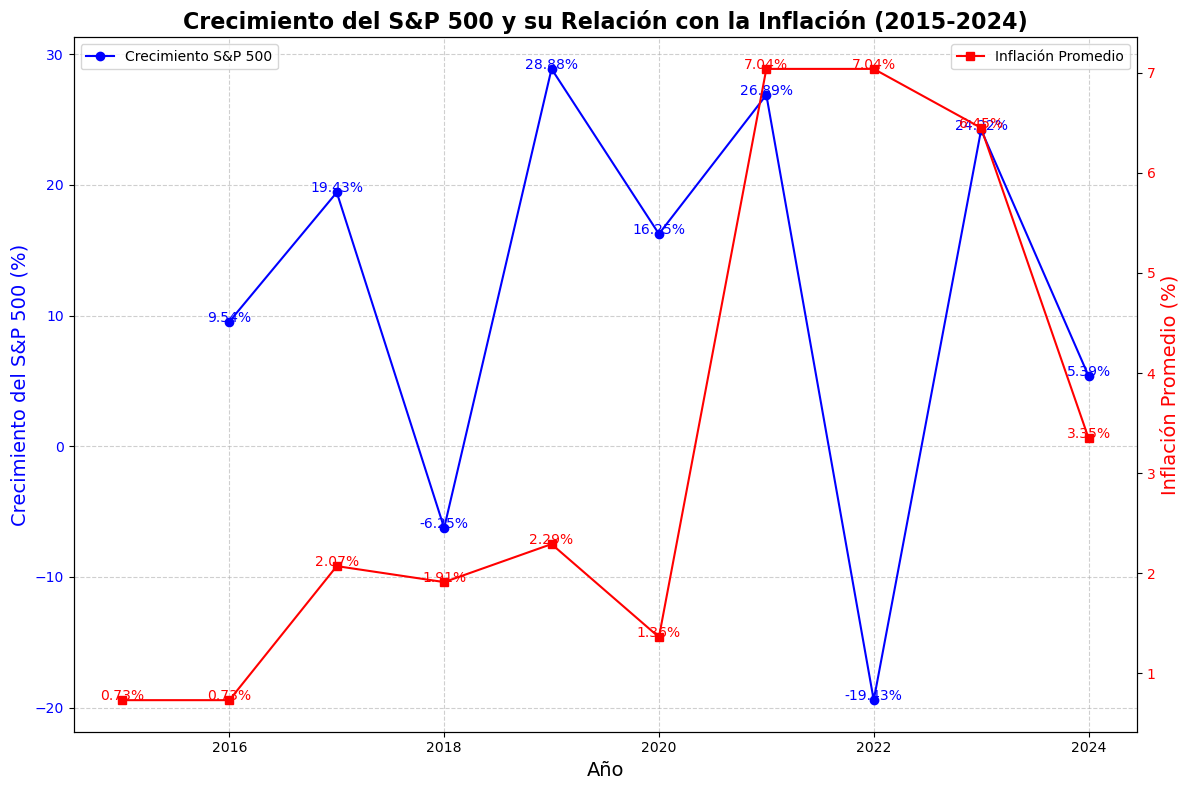

In [36]:
# Mejorado para consulta 4: Crecimiento del S&P 500 y relación con la inflación
fig, ax1 = plt.subplots(figsize=(12, 8))

# Gráfico de líneas para el crecimiento del S&P 500
ax1.plot(df4['year'], df4['sp500_growth'], color='blue', marker='o', label='Crecimiento S&P 500')
ax1.set_xlabel('Año', fontsize=14)
ax1.set_ylabel('Crecimiento del S&P 500 (%)', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')

# Añadir etiquetas de datos en el gráfico de S&P 500
for i in range(len(df4)):
    ax1.text(df4['year'][i], df4['sp500_growth'][i], f"{df4['sp500_growth'][i]:.2f}%", fontsize=10, ha='center', color='blue')

# Crear un segundo eje Y para la inflación
ax2 = ax1.twinx()
ax2.plot(df4['year'], df4['avg_inflation'], color='red', marker='s', label='Inflación Promedio')
ax2.set_ylabel('Inflación Promedio (%)', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')

# Añadir etiquetas de datos en el gráfico de inflación
for i in range(len(df4)):
    ax2.text(df4['year'][i], df4['avg_inflation'][i], f"{df4['avg_inflation'][i]:.2f}%", fontsize=10, ha='center', color='red')

# Título
plt.title('Crecimiento del S&P 500 y su Relación con la Inflación (2015-2024)', fontsize=16, fontweight='bold')

# Leyendas
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Cuadrícula
ax1.grid(True, linestyle='--', alpha=0.6)

# Mostrar gráfico
plt.tight_layout()
plt.show()


In [37]:
# Consulta 5: Promedio y volatilidad de Bitcoin en condiciones de alta volatilidad e inflación
consulta5 = """
SELECT
    AVG(a.price_bitcoin) AS avg_bitcoin_price,
    STD(a.price_bitcoin) AS volatility_bitcoin,
    AVG(e.vix) AS avg_vix,
    AVG(e.inflation) AS avg_inflation
FROM
    assets a
JOIN
    economic_factors e ON a.id_date = e.id_date
WHERE
    e.vix > 30 AND e.inflation > 3;
"""

# Ejecutar la consulta y cargar los datos en un DataFrame
df5 = pd.read_sql(consulta5, con=engine)

In [38]:
# Mostrar el DataFrame resultante
df5

,avg_bitcoin_price,volatility_bitcoin,avg_vix,avg_inflation
0,29918.191489,9361.21928,31.940213,7.04
